# This notebook is to test python plotting .mat TTC files



In [1]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import sympy

# Wrapper function for easily displaying markdown text
disp_md = lambda text: display(Markdown(text))

In [2]:
r2  = io.loadmat('TTC_data/RunData_Cornering/B2356run5.mat')
print(r2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AMBTMP', 'ET', 'FX', 'FY', 'FZ', 'IA', 'MX', 'MZ', 'N', 'NFX', 'NFY', 'P', 'RE', 'RL', 'RST', 'RUN', 'SA', 'SL', 'SR', 'TSTC', 'TSTI', 'TSTO', 'V', 'channel', 'source', 'testid', 'tireid'])


### Plot some stuff

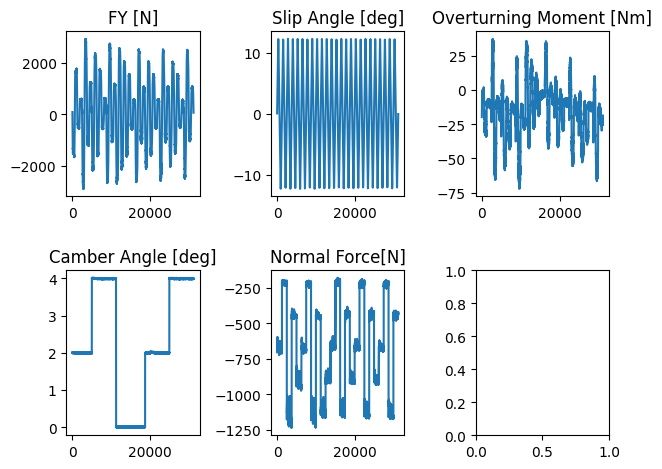

In [3]:
V = r2['V'].flatten()
SA = r2['SA'].flatten()
IA = r2['IA'].flatten()
FZ = r2['FZ'].flatten()
FY = r2['FY'].flatten()
MX = r2['MX'].flatten()


fig, ax = plt.subplots(2,3)
ax[0,0].plot(FY)
ax[0,1].plot(SA)
ax[1,0].plot(IA)
ax[1,1].plot(FZ)
ax[0,2].plot(MX)


ax[0,0].title.set_text('FY [N]')
ax[0,1].title.set_text('Slip Angle [deg]')
ax[1,0].title.set_text('Camber Angle [deg]')
ax[1,1].title.set_text('Normal Force[N]')
ax[0,2].title.set_text('Overturning Moment [Nm]')




fig.tight_layout(h_pad=2)
plt.show()

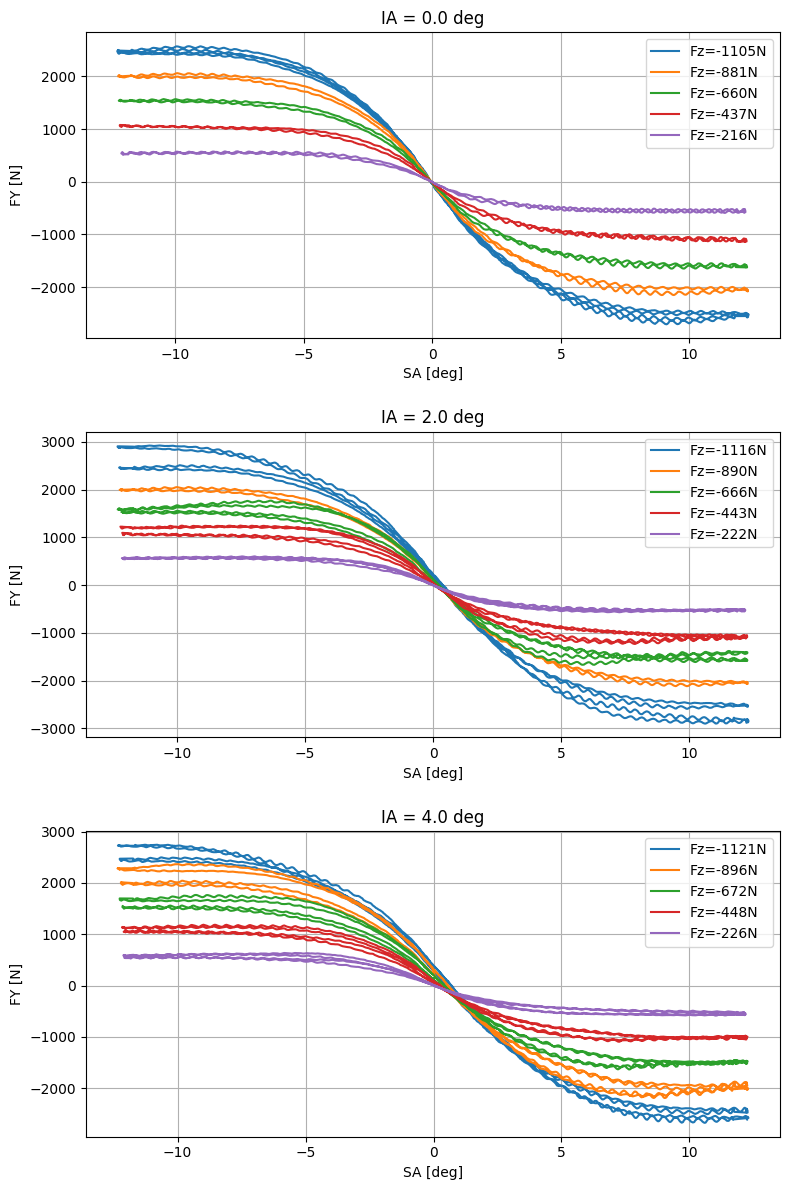

In [4]:
import numpy as np

def process_stepwise_data(stepped_data, extr_data = None, threshold=0.2, min_step_length=100):
    """
    Process data by identifying steps, removing transients, and returning step averages and data.
    
    Parameters:
    - stepped_data: array-like, input stepwise data
    - extr_data: array-like, input extra data to be processed using step data
    - threshold: float, relative change threshold to detect a new step
    - min_step_length: int, minimum number of points to consider a stable step
    
    Returns:
    - list of tuples, each containing (step_average, step_data_array)
    """
    if len(stepped_data) == 0:
        return []

    
    diffs = [np.abs(stepped_data[i+1]-stepped_data[i]) for i in range(len(stepped_data)-1)]

    #find all indices of transients
    absolute_threshold = threshold*np.max(diffs)
    transient_indices = np.where(diffs > absolute_threshold)[0] + 1
    transient_indices = np.concatenate(([0], transient_indices, [len(stepped_data)]))

    #find step edges from transient indices 
    step_indices = []
    for i in range(len(transient_indices)-1):
        start = transient_indices[i] 
        end = transient_indices[i + 1]

        # Only include steps with sufficient length
        if (end-start) >= min_step_length:
            step_indices.append((start,end))
    

    #process step indices into list of tuples with average step value and step arrays
    if extr_data != None:
        return [
            (np.mean(step := stepped_data[start:end]), 
            [step, *[d[start:end] for d in extr_data]])
            for start, end in step_indices
        ]    
    
    return [(np.mean(step := stepped_data[start:end]), step) for start, end in step_indices ]
    

def regroup_similar_steps(tuples_array, rel_tol=0.05, absolute_tol=0.05):
    """
    Groups tuples with similar averages and concatenates their data arrays.
    
    Args:
        tuples_array: List of tuples in format [(avg, data_array), ...]
        rel_tol: Relative tolerance for considering averages similar (default: 5%)
        absolute_tol: Absolute tolerance to be used when values are < 1 (default: 0.5)
    
    Returns:
        List of regrouped tuples in same format
    """
    if not tuples_array:
        return []
    
    # Sort by average to group similar values together
    sorted_tuples = sorted(tuples_array, key=lambda x: x[0])
    
    regrouped = []
    current_avg, current_data = sorted_tuples[0]
    
    for avg, data in sorted_tuples[1:]:
        # Check if averages are similar within relative tolerance
        if np.isclose(avg, current_avg, rtol=rel_tol) or np.isclose(current_avg, avg, atol=absolute_tol):
            # Concatenate along first axis (vertically)
            current_data = np.concatenate((current_data, data), axis=1)
        else:
            # Add to results and start new group
            regrouped.append((current_avg, current_data))
            current_avg, current_data = avg, data
    
    # Add the last group
    regrouped.append((current_avg, current_data))
    
    return regrouped


camber_steps = regroup_similar_steps(process_stepwise_data(IA, extr_data=[FZ, SA, FY]), rel_tol=0.05)

#removes the second element because it was garbage data
#del camber_steps[1]

fig, ax = plt.subplots(3,1, figsize=(8, 12))
ax = ax.flatten()
for i, c_step in enumerate(camber_steps):
    camber_avg, (ca, fz, sa, fy) = c_step

    fz_steps = regroup_similar_steps(process_stepwise_data(fz, extr_data = [sa, fy]))

    for step in fz_steps:
        slip_avg, (fz, sa, fy) = step

        ax[i].plot(sa, fy, label = f"Fz={slip_avg:.0f}N")

    ax[i].set_title(f'IA = {camber_avg:.1f} deg')
    ax[i].set_xlabel('SA [deg]')
    ax[i].set_ylabel('FY [N]')
    ax[i].grid()
    ax[i].legend()


fig.tight_layout(h_pad=2)
plt.show()

### Peak force

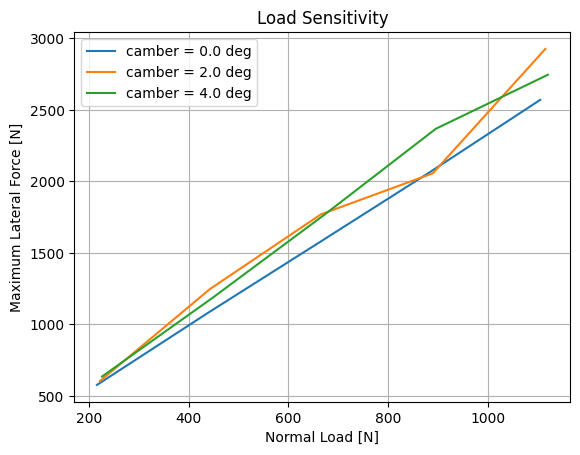

In [5]:
for c_step in camber_steps:
    camber_avg, (ca, fz, sa, fy) = c_step

    fz_steps = regroup_similar_steps(process_stepwise_data(fz, extr_data = [sa, fy]))

    load_sens_data = np.array([ [np.abs(fz_avg), fy[np.argmax(fy)]] for fz_avg, (fz, sa, fy) in fz_steps ]).T

    plt.plot(*load_sens_data, label = 'camber = {:.1f} deg'.format(camber_avg))

plt.title('Load Sensitivity')
plt.xlabel('Normal Load [N]')
plt.ylabel('Maximum Lateral Force [N]')
plt.legend()
plt.grid()
plt.show()